In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam

In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    print("데이터 값의 범위 : ", np.min(x_train), np.max(x_train) )
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)


In [3]:
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

11501568/11490434 [==============================] - 0s 0us/step
데이터 값의 범위 :  -1.0 1.0
(60000, 784)


In [4]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [5]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

g=create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               8

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

d =create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)    # 레이어를 객체로 그룹화
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

# g = create_generator()     # 생성자
# d = create_discriminator()  # 판별자

gan = create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1486352   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [8]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [9]:
def training(epochs=1, batch_size=128):
    
    # 데이터 불러오기(Loading the data)
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Noise를 이용하여 MNIST이미지 만들기( Generate fake MNIST images from noised input )
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            # Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


데이터 값의 범위 :  -1.0 1.0
Epoch 1


100%|██████████| 256/256 [00:26<00:00,  9.60it/s]


Epoch 2


100%|██████████| 256/256 [00:23<00:00, 10.97it/s]


Epoch 3


100%|██████████| 256/256 [00:23<00:00, 10.96it/s]


Epoch 4


100%|██████████| 256/256 [00:23<00:00, 10.88it/s]


Epoch 5


100%|██████████| 256/256 [00:23<00:00, 10.93it/s]


Epoch 6


100%|██████████| 256/256 [00:23<00:00, 11.06it/s]


Epoch 7


100%|██████████| 256/256 [00:23<00:00, 11.11it/s]


Epoch 8


100%|██████████| 256/256 [00:23<00:00, 10.91it/s]


Epoch 9


100%|██████████| 256/256 [00:23<00:00, 11.06it/s]


Epoch 10


100%|██████████| 256/256 [00:23<00:00, 11.08it/s]


Epoch 11


100%|██████████| 256/256 [00:23<00:00, 11.08it/s]


Epoch 12


100%|██████████| 256/256 [00:23<00:00, 10.96it/s]


Epoch 13


100%|██████████| 256/256 [00:23<00:00, 11.00it/s]


Epoch 14


100%|██████████| 256/256 [00:23<00:00, 10.98it/s]


Epoch 15


100%|██████████| 256/256 [00:23<00:00, 10.92it/s]


Epoch 16


100%|██████████| 256/256 [00:23<00:00, 10.88it/s]


Epoch 17


100%|██████████| 256/256 [00:23<00:00, 10.97it/s]


Epoch 18


100%|██████████| 256/256 [00:22<00:00, 11.14it/s]


Epoch 19


100%|██████████| 256/256 [00:22<00:00, 11.22it/s]


Epoch 20


100%|██████████| 256/256 [00:23<00:00, 10.90it/s]


Epoch 21


100%|██████████| 256/256 [00:22<00:00, 11.17it/s]


Epoch 22


100%|██████████| 256/256 [00:23<00:00, 10.97it/s]


Epoch 23


100%|██████████| 256/256 [00:23<00:00, 10.91it/s]


Epoch 24


100%|██████████| 256/256 [00:23<00:00, 11.07it/s]


Epoch 25


100%|██████████| 256/256 [00:23<00:00, 11.02it/s]


Epoch 26


100%|██████████| 256/256 [00:22<00:00, 11.23it/s]


Epoch 27


100%|██████████| 256/256 [00:22<00:00, 11.20it/s]


Epoch 28


100%|██████████| 256/256 [00:23<00:00, 10.82it/s]


Epoch 29


100%|██████████| 256/256 [00:22<00:00, 11.16it/s]


Epoch 30


100%|██████████| 256/256 [00:23<00:00, 11.08it/s]


Epoch 31


100%|██████████| 256/256 [00:22<00:00, 11.26it/s]


Epoch 32


100%|██████████| 256/256 [00:22<00:00, 11.18it/s]


Epoch 33


100%|██████████| 256/256 [00:23<00:00, 11.08it/s]


Epoch 34


100%|██████████| 256/256 [00:23<00:00, 11.04it/s]


Epoch 35


100%|██████████| 256/256 [00:23<00:00, 11.09it/s]


Epoch 36


100%|██████████| 256/256 [00:22<00:00, 11.18it/s]


Epoch 37


100%|██████████| 256/256 [00:23<00:00, 11.13it/s]


Epoch 38


100%|██████████| 256/256 [00:23<00:00, 10.83it/s]


Epoch 39


100%|██████████| 256/256 [00:22<00:00, 11.23it/s]


Epoch 40


100%|██████████| 256/256 [00:23<00:00, 11.11it/s]


Epoch 41


100%|██████████| 256/256 [00:23<00:00, 11.07it/s]


Epoch 42


100%|██████████| 256/256 [00:23<00:00, 11.07it/s]


Epoch 43


100%|██████████| 256/256 [00:23<00:00, 11.01it/s]


Epoch 44


100%|██████████| 256/256 [00:23<00:00, 11.02it/s]


Epoch 45


100%|██████████| 256/256 [00:23<00:00, 10.97it/s]


Epoch 46


100%|██████████| 256/256 [00:23<00:00, 11.00it/s]


Epoch 47


100%|██████████| 256/256 [00:23<00:00, 10.96it/s]


Epoch 48


100%|██████████| 256/256 [00:23<00:00, 10.70it/s]


Epoch 49


100%|██████████| 256/256 [00:23<00:00, 11.12it/s]


Epoch 50


100%|██████████| 256/256 [00:22<00:00, 11.19it/s]


Epoch 51


100%|██████████| 256/256 [00:23<00:00, 10.79it/s]


Epoch 52


100%|██████████| 256/256 [00:23<00:00, 10.98it/s]


Epoch 53


100%|██████████| 256/256 [00:22<00:00, 11.14it/s]


Epoch 54


100%|██████████| 256/256 [00:23<00:00, 11.09it/s]


Epoch 55


100%|██████████| 256/256 [00:23<00:00, 10.95it/s]


Epoch 56


100%|██████████| 256/256 [00:23<00:00, 11.05it/s]


Epoch 57


100%|██████████| 256/256 [00:23<00:00, 10.77it/s]


Epoch 58


100%|██████████| 256/256 [00:23<00:00, 11.05it/s]


Epoch 59


100%|██████████| 256/256 [00:22<00:00, 11.30it/s]


Epoch 60


100%|██████████| 256/256 [00:22<00:00, 11.15it/s]


Epoch 61


100%|██████████| 256/256 [00:22<00:00, 11.18it/s]


Epoch 62


100%|██████████| 256/256 [00:23<00:00, 11.10it/s]


Epoch 63


100%|██████████| 256/256 [00:23<00:00, 11.09it/s]


Epoch 64


100%|██████████| 256/256 [00:23<00:00, 11.11it/s]


Epoch 65


100%|██████████| 256/256 [00:23<00:00, 10.82it/s]


Epoch 66


100%|██████████| 256/256 [00:22<00:00, 11.19it/s]


Epoch 67


100%|██████████| 256/256 [00:22<00:00, 11.23it/s]


Epoch 68


100%|██████████| 256/256 [00:23<00:00, 11.04it/s]


Epoch 69


100%|██████████| 256/256 [00:23<00:00, 11.03it/s]


Epoch 70


100%|██████████| 256/256 [00:23<00:00, 11.13it/s]


Epoch 71


100%|██████████| 256/256 [00:23<00:00, 11.13it/s]


Epoch 72


100%|██████████| 256/256 [00:22<00:00, 11.36it/s]


Epoch 73


100%|██████████| 256/256 [00:23<00:00, 10.67it/s]


Epoch 74


100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


Epoch 75


100%|██████████| 256/256 [00:23<00:00, 11.04it/s]


Epoch 76


100%|██████████| 256/256 [00:22<00:00, 11.16it/s]


Epoch 77


100%|██████████| 256/256 [00:23<00:00, 11.08it/s]


Epoch 78


100%|██████████| 256/256 [00:23<00:00, 11.00it/s]


Epoch 79


100%|██████████| 256/256 [00:23<00:00, 11.09it/s]


Epoch 80


100%|██████████| 256/256 [00:23<00:00, 10.83it/s]


Epoch 81


100%|██████████| 256/256 [00:22<00:00, 11.20it/s]


Epoch 82


100%|██████████| 256/256 [00:23<00:00, 11.05it/s]


Epoch 83


100%|██████████| 256/256 [00:23<00:00, 10.78it/s]


Epoch 84


100%|██████████| 256/256 [00:22<00:00, 11.20it/s]


Epoch 85


100%|██████████| 256/256 [00:23<00:00, 10.92it/s]


Epoch 86


100%|██████████| 256/256 [00:23<00:00, 11.07it/s]


Epoch 87


100%|██████████| 256/256 [00:23<00:00, 11.08it/s]


Epoch 88


100%|██████████| 256/256 [00:22<00:00, 11.13it/s]


Epoch 89


100%|██████████| 256/256 [00:23<00:00, 10.94it/s]


Epoch 90


100%|██████████| 256/256 [00:23<00:00, 11.00it/s]


Epoch 91


100%|██████████| 256/256 [00:24<00:00, 10.63it/s]


Epoch 92


100%|██████████| 256/256 [00:22<00:00, 11.13it/s]


Epoch 93


100%|██████████| 256/256 [00:23<00:00, 10.92it/s]


Epoch 94


100%|██████████| 256/256 [00:23<00:00, 10.89it/s]


Epoch 95


100%|██████████| 256/256 [00:23<00:00, 10.91it/s]


Epoch 96


100%|██████████| 256/256 [00:23<00:00, 11.00it/s]


Epoch 97


100%|██████████| 256/256 [00:23<00:00, 11.06it/s]


Epoch 98


100%|██████████| 256/256 [00:23<00:00, 10.90it/s]


Epoch 99


100%|██████████| 256/256 [00:24<00:00, 10.49it/s]


Epoch 100


100%|██████████| 256/256 [00:23<00:00, 10.81it/s]


Epoch 101


100%|██████████| 256/256 [00:23<00:00, 10.89it/s]


Epoch 102


100%|██████████| 256/256 [00:22<00:00, 11.20it/s]


Epoch 103


100%|██████████| 256/256 [00:24<00:00, 10.50it/s]


Epoch 104


100%|██████████| 256/256 [00:23<00:00, 10.99it/s]


Epoch 105


100%|██████████| 256/256 [00:23<00:00, 10.86it/s]


Epoch 106


100%|██████████| 256/256 [00:23<00:00, 11.00it/s]


Epoch 107


100%|██████████| 256/256 [00:23<00:00, 11.13it/s]


Epoch 108


100%|██████████| 256/256 [00:23<00:00, 10.96it/s]


Epoch 109


100%|██████████| 256/256 [00:23<00:00, 10.80it/s]


Epoch 110


100%|██████████| 256/256 [00:23<00:00, 10.96it/s]


Epoch 111


100%|██████████| 256/256 [00:23<00:00, 10.92it/s]


Epoch 112


100%|██████████| 256/256 [00:22<00:00, 11.24it/s]


Epoch 113


100%|██████████| 256/256 [00:24<00:00, 10.35it/s]


Epoch 114


100%|██████████| 256/256 [00:23<00:00, 10.95it/s]


Epoch 115


100%|██████████| 256/256 [00:23<00:00, 10.96it/s]


Epoch 116


100%|██████████| 256/256 [00:23<00:00, 10.89it/s]


Epoch 117


100%|██████████| 256/256 [00:23<00:00, 10.80it/s]


Epoch 118


100%|██████████| 256/256 [00:23<00:00, 10.94it/s]


Epoch 119


100%|██████████| 256/256 [00:23<00:00, 10.96it/s]


Epoch 120


100%|██████████| 256/256 [00:23<00:00, 10.97it/s]


Epoch 121


100%|██████████| 256/256 [00:23<00:00, 10.90it/s]


Epoch 122


100%|██████████| 256/256 [00:23<00:00, 10.97it/s]


Epoch 123


100%|██████████| 256/256 [00:23<00:00, 11.05it/s]


Epoch 124


100%|██████████| 256/256 [00:23<00:00, 10.99it/s]


Epoch 125


100%|██████████| 256/256 [00:23<00:00, 10.76it/s]


Epoch 126


100%|██████████| 256/256 [00:23<00:00, 10.94it/s]


Epoch 127


100%|██████████| 256/256 [00:23<00:00, 10.78it/s]


Epoch 128


100%|██████████| 256/256 [00:24<00:00, 10.50it/s]


Epoch 129


100%|██████████| 256/256 [00:23<00:00, 11.03it/s]


Epoch 130


100%|██████████| 256/256 [00:23<00:00, 11.02it/s]


Epoch 131


100%|██████████| 256/256 [00:23<00:00, 11.06it/s]


Epoch 132


100%|██████████| 256/256 [00:22<00:00, 11.21it/s]


Epoch 133


100%|██████████| 256/256 [00:23<00:00, 11.03it/s]


Epoch 134


100%|██████████| 256/256 [00:23<00:00, 11.11it/s]


Epoch 135


100%|██████████| 256/256 [00:23<00:00, 11.03it/s]


Epoch 136


100%|██████████| 256/256 [00:23<00:00, 10.98it/s]


Epoch 137


100%|██████████| 256/256 [00:22<00:00, 11.22it/s]


Epoch 138


100%|██████████| 256/256 [00:22<00:00, 11.21it/s]


Epoch 139


100%|██████████| 256/256 [00:24<00:00, 10.65it/s]


Epoch 140


100%|██████████| 256/256 [00:22<00:00, 11.21it/s]


Epoch 141


100%|██████████| 256/256 [00:22<00:00, 11.20it/s]


Epoch 142


100%|██████████| 256/256 [00:22<00:00, 11.37it/s]


Epoch 143


100%|██████████| 256/256 [00:22<00:00, 11.33it/s]


Epoch 144


100%|██████████| 256/256 [00:22<00:00, 11.20it/s]


Epoch 145


100%|██████████| 256/256 [00:23<00:00, 10.69it/s]


Epoch 146


100%|██████████| 256/256 [00:22<00:00, 11.15it/s]


Epoch 147


100%|██████████| 256/256 [00:22<00:00, 11.16it/s]


Epoch 148


100%|██████████| 256/256 [00:22<00:00, 11.26it/s]


Epoch 149


100%|██████████| 256/256 [00:22<00:00, 11.26it/s]


Epoch 150


100%|██████████| 256/256 [00:22<00:00, 11.39it/s]


Epoch 151


100%|██████████| 256/256 [00:23<00:00, 11.12it/s]


Epoch 152


100%|██████████| 256/256 [00:22<00:00, 11.19it/s]


Epoch 153


100%|██████████| 256/256 [00:22<00:00, 11.18it/s]


Epoch 154


100%|██████████| 256/256 [00:23<00:00, 11.12it/s]


Epoch 155


100%|██████████| 256/256 [00:22<00:00, 11.27it/s]


Epoch 156


100%|██████████| 256/256 [00:22<00:00, 11.29it/s]


Epoch 157


100%|██████████| 256/256 [00:23<00:00, 10.67it/s]


Epoch 158


100%|██████████| 256/256 [00:23<00:00, 11.09it/s]


Epoch 159


100%|██████████| 256/256 [00:22<00:00, 11.20it/s]


Epoch 160


100%|██████████| 256/256 [00:23<00:00, 11.13it/s]


Epoch 161


100%|██████████| 256/256 [00:23<00:00, 11.01it/s]


Epoch 162


100%|██████████| 256/256 [00:22<00:00, 11.26it/s]


Epoch 163


100%|██████████| 256/256 [00:22<00:00, 11.20it/s]


Epoch 164


100%|██████████| 256/256 [00:23<00:00, 10.72it/s]


Epoch 165


100%|██████████| 256/256 [00:22<00:00, 11.23it/s]


Epoch 166


100%|██████████| 256/256 [00:23<00:00, 11.03it/s]


Epoch 167


100%|██████████| 256/256 [00:22<00:00, 11.28it/s]


Epoch 168


100%|██████████| 256/256 [00:22<00:00, 11.34it/s]


Epoch 169


100%|██████████| 256/256 [00:22<00:00, 11.20it/s]


Epoch 170


100%|██████████| 256/256 [00:22<00:00, 11.17it/s]


Epoch 171


100%|██████████| 256/256 [00:23<00:00, 11.05it/s]


Epoch 172


100%|██████████| 256/256 [00:22<00:00, 11.14it/s]


Epoch 173


100%|██████████| 256/256 [00:22<00:00, 11.23it/s]


Epoch 174


100%|██████████| 256/256 [00:22<00:00, 11.29it/s]


Epoch 175


100%|██████████| 256/256 [00:23<00:00, 11.07it/s]


Epoch 176


100%|██████████| 256/256 [00:22<00:00, 11.17it/s]


Epoch 177


100%|██████████| 256/256 [00:23<00:00, 11.08it/s]


Epoch 178


100%|██████████| 256/256 [00:24<00:00, 10.46it/s]


Epoch 179


100%|██████████| 256/256 [00:22<00:00, 11.19it/s]


Epoch 180


100%|██████████| 256/256 [00:23<00:00, 11.05it/s]


Epoch 181


100%|██████████| 256/256 [00:22<00:00, 11.17it/s]


Epoch 182


100%|██████████| 256/256 [00:22<00:00, 11.19it/s]


Epoch 183


100%|██████████| 256/256 [00:22<00:00, 11.23it/s]


Epoch 184


100%|██████████| 256/256 [00:23<00:00, 11.08it/s]


Epoch 185


100%|██████████| 256/256 [00:23<00:00, 11.01it/s]


Epoch 186


100%|██████████| 256/256 [00:24<00:00, 10.46it/s]


Epoch 187


100%|██████████| 256/256 [00:23<00:00, 11.07it/s]


Epoch 188


100%|██████████| 256/256 [00:23<00:00, 10.96it/s]


Epoch 189


100%|██████████| 256/256 [00:23<00:00, 11.06it/s]


Epoch 190


100%|██████████| 256/256 [00:23<00:00, 11.11it/s]


Epoch 191


100%|██████████| 256/256 [00:22<00:00, 11.16it/s]


Epoch 192


100%|██████████| 256/256 [00:23<00:00, 11.03it/s]


Epoch 193


100%|██████████| 256/256 [00:22<00:00, 11.22it/s]


Epoch 194


100%|██████████| 256/256 [00:23<00:00, 10.86it/s]


Epoch 195


100%|██████████| 256/256 [00:23<00:00, 10.98it/s]


Epoch 196


100%|██████████| 256/256 [00:23<00:00, 10.85it/s]


Epoch 197


100%|██████████| 256/256 [00:23<00:00, 10.97it/s]


Epoch 198


100%|██████████| 256/256 [00:23<00:00, 10.87it/s]


Epoch 199


100%|██████████| 256/256 [00:23<00:00, 11.05it/s]


Epoch 200


100%|██████████| 256/256 [00:24<00:00, 10.46it/s]


CPU times: user 1h 13min 55s, sys: 6min 2s, total: 1h 19min 58s
Wall time: 1h 18min 1s


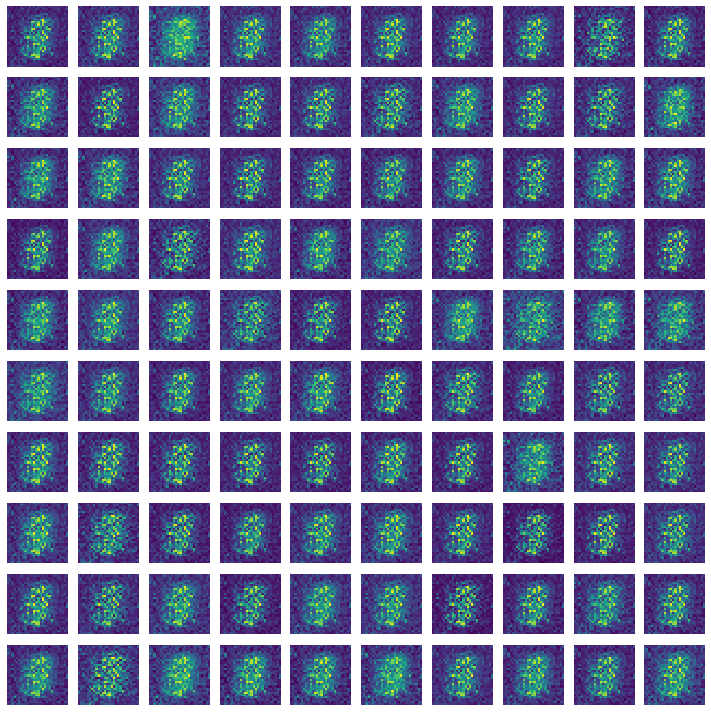

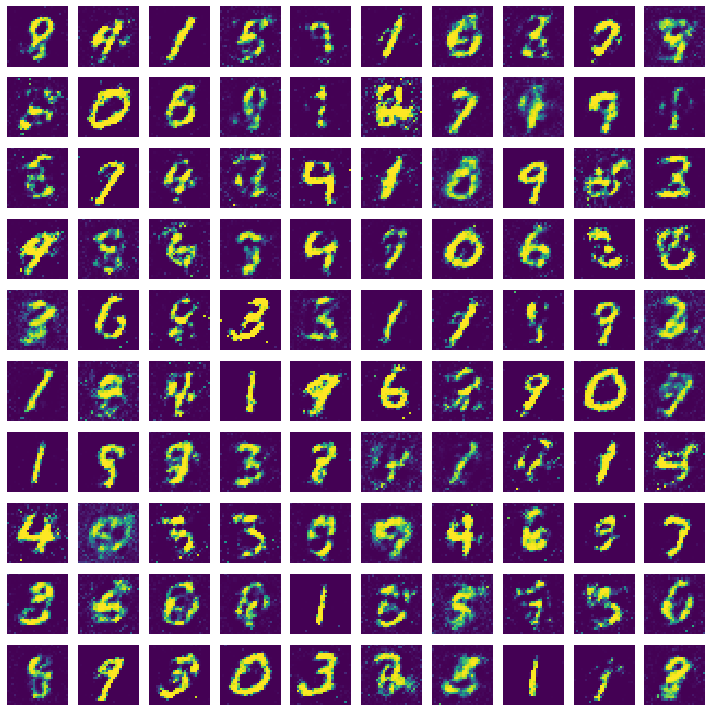

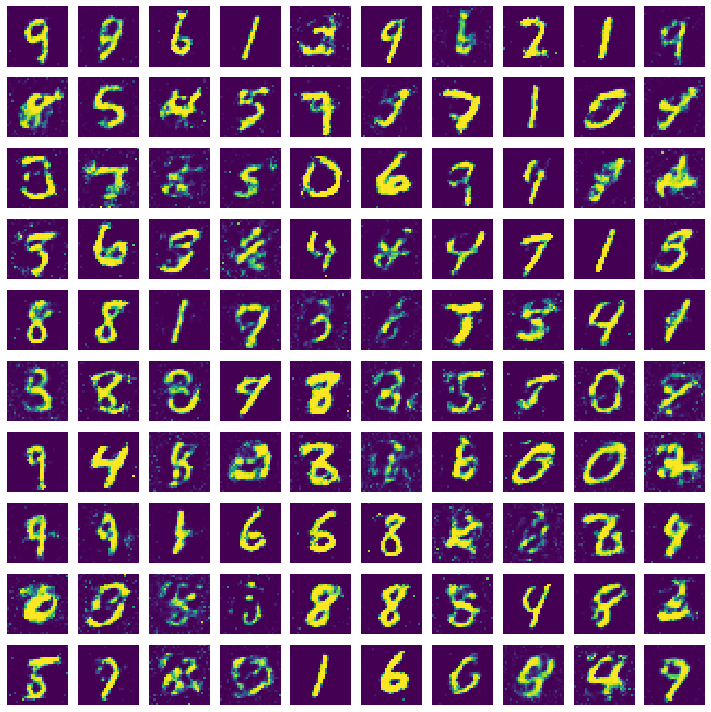

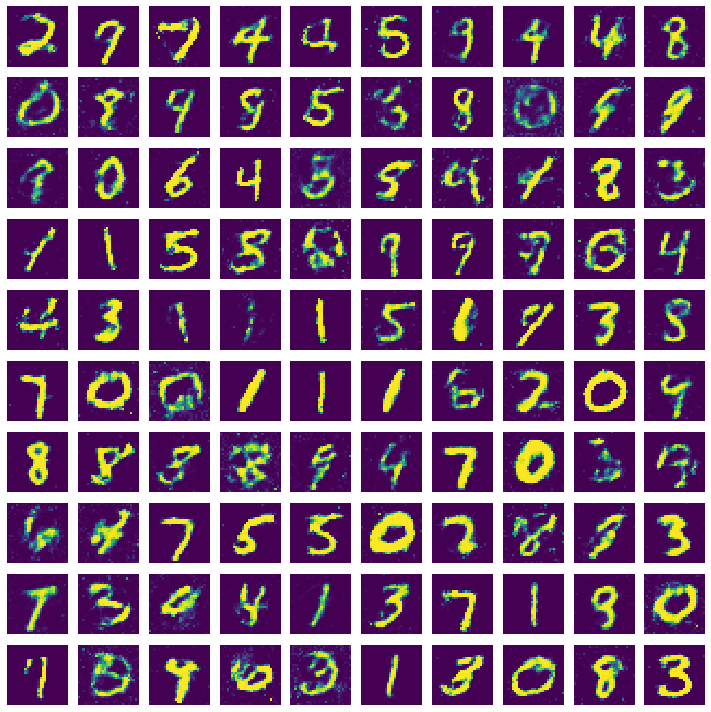

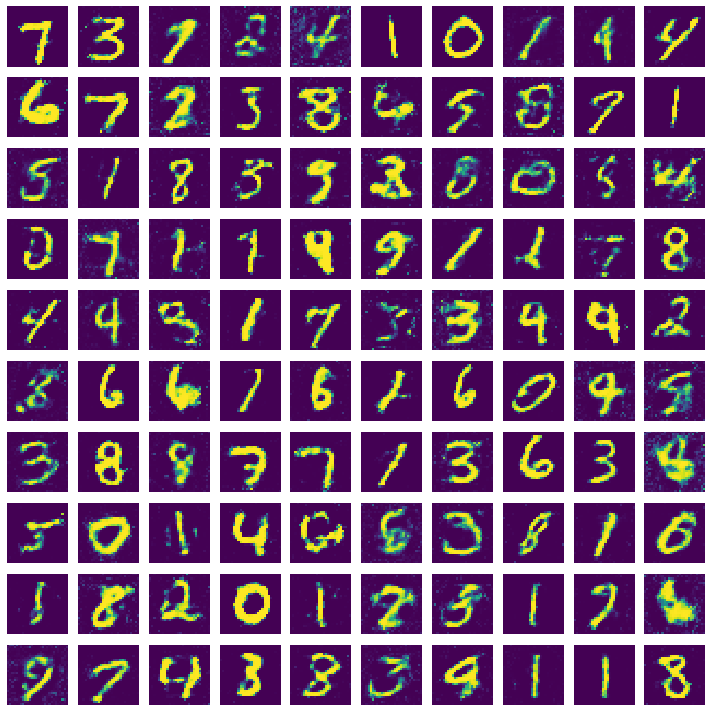

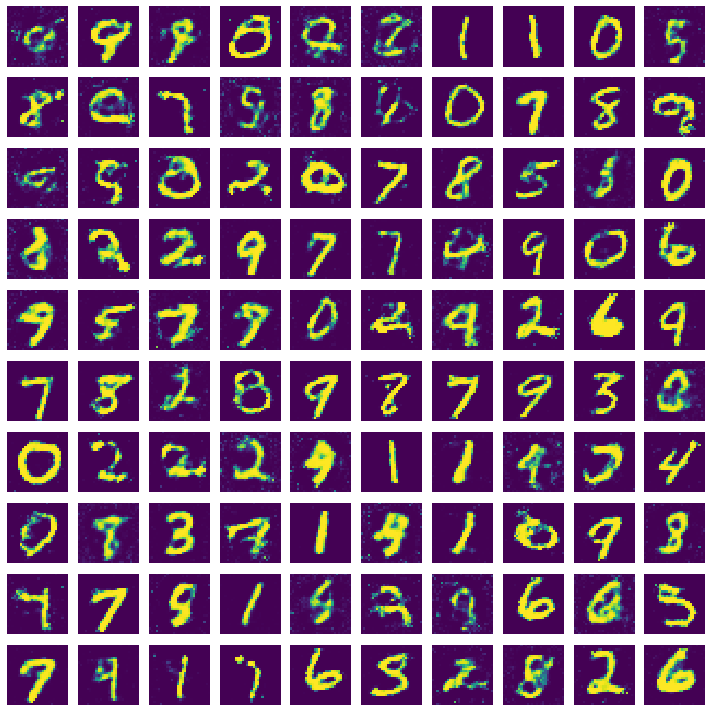

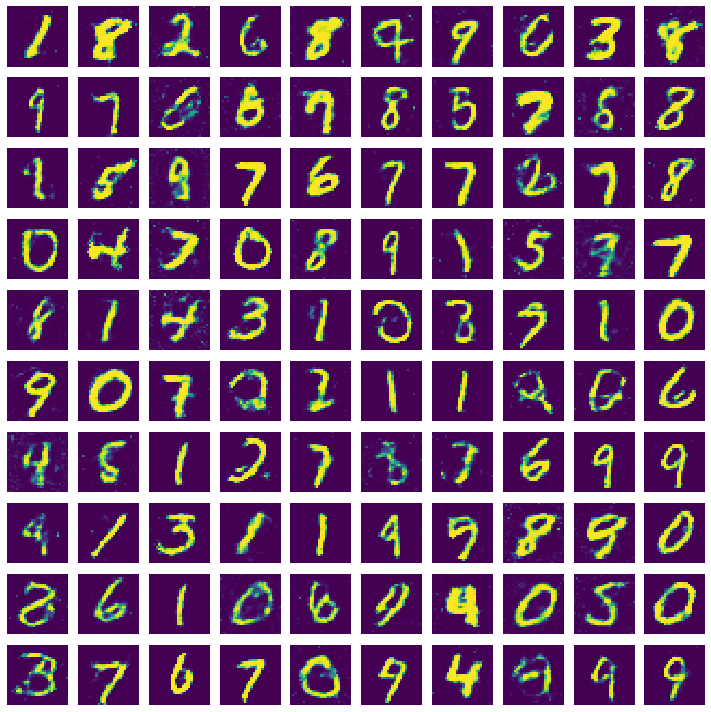

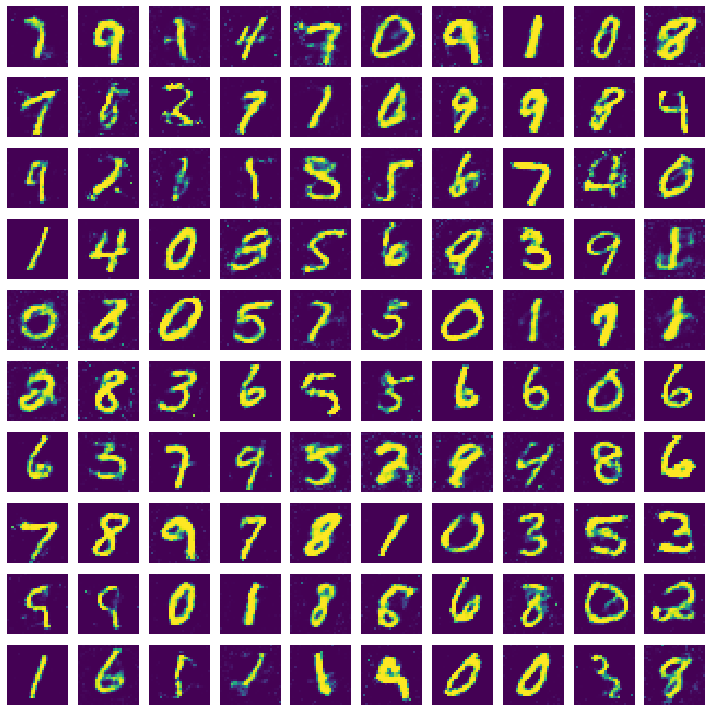

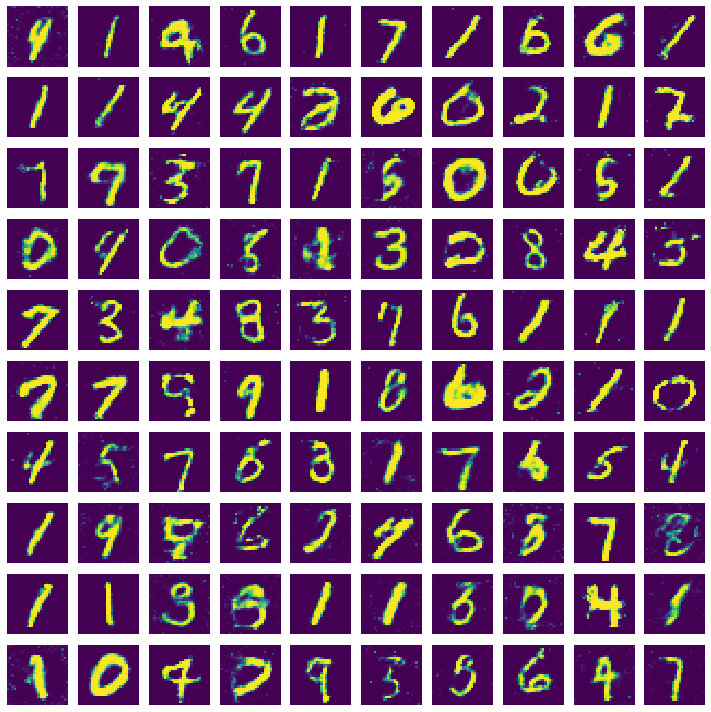

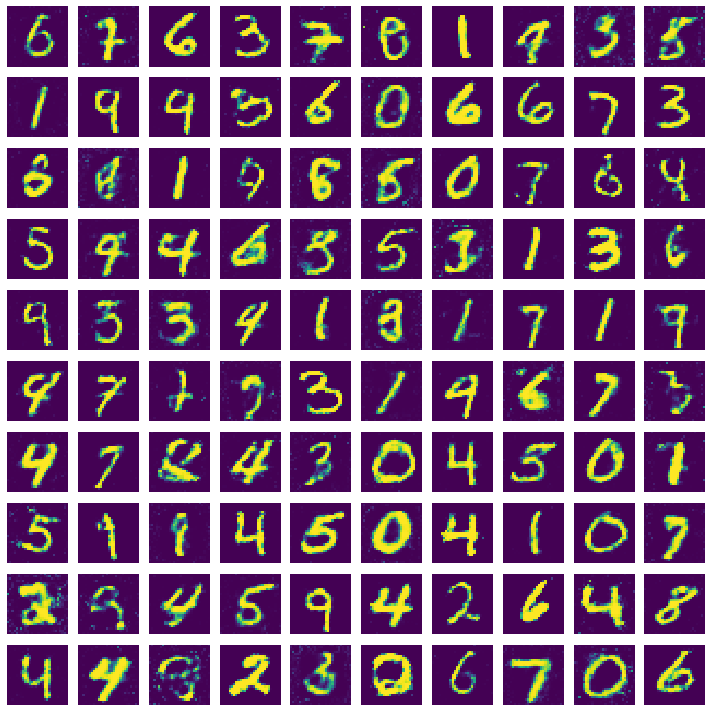

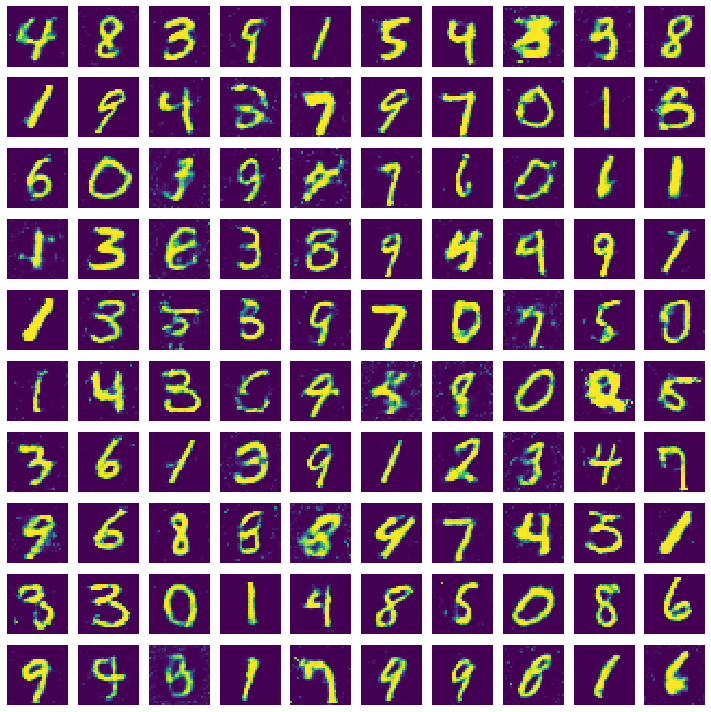

In [10]:
%%time

training(200,256)